<a href="https://colab.research.google.com/github/SantanuOjha/Flood-Damage-Assessment/blob/main/DamageAssesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import kagglehub

path = kagglehub.dataset_download("tunguz/xview2-challenge-dataset-train-and-test")

print("Path to dataset files:", path)

100%|██████████| 10.3G/10.3G [01:59<00:00, 92.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/tunguz/xview2-challenge-dataset-train-and-test/versions/3


In [2]:
!pip install -q segmentation-models
!pip install -q Pillow scikit-image

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.5 MB/s eta 0:00:00


In [3]:
import os
os.environ['SM_FRAMEWORK'] = 'tf.keras'

import json
import numpy as np
import pandas as pd
from PIL import Image
from skimage.draw import polygon as draw_polygon

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import Sequence

import segmentation_models as sm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

print("TensorFlow version:", tf.__version__)
print("Keras framework:", sm.framework())

Segmentation Models: using `tf.keras` framework.
TensorFlow version: 2.18.0
Keras framework: tf.keras


In [5]:
base_path = "/root/.cache/kagglehub/datasets/tunguz/xview2-challenge-dataset-train-and-test/versions/3"
#base_path = "/kaggle/input/xview2-challenge-dataset-train-and-test"
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')

train_images_path = os.path.join(train_path, 'train/images')
train_labels_path = os.path.join(train_path, 'train/labels')

print("Sample image files:", os.listdir(train_images_path)[:5])
print("Sample label files:", os.listdir(train_labels_path)[:5])

Sample image files: ['hurricane-michael_00000048_post_disaster.png', 'socal-fire_00000211_pre_disaster.png', 'hurricane-harvey_00000071_post_disaster.png', 'hurricane-harvey_00000423_pre_disaster.png', 'socal-fire_00000578_pre_disaster.png']
Sample label files: ['hurricane-harvey_00000433_post_disaster.json', 'hurricane-matthew_00000335_pre_disaster.json', 'midwest-flooding_00000028_post_disaster.json', 'mexico-earthquake_00000101_pre_disaster.json', 'hurricane-matthew_00000083_pre_disaster.json']


In [6]:
CLASS_MAPPING = {
    "no-damage": 1,
    "minor-damage": 2,
    "major-damage": 3,
    "destroyed": 4,
    "un-classified": 0
}

def create_mask_from_json(json_path, target_shape=(1024, 1024)):
    """
    Creates a segmentation mask from a geojson label file.
    The background is initialized to 0 (no building).
    """
    mask = np.zeros(target_shape, dtype=np.uint8)

    with open(json_path) as f:
        data = json.load(f)

    for feature in data['features']['xy']:
        poly_coords = np.array(feature['wkt'].replace('POLYGON ((', '').replace('))', '').split(','))
        poly_coords = np.array([p.split() for p in poly_coords], dtype=np.float32)

        damage_type = feature['properties']['subtype']
        class_id = CLASS_MAPPING.get(damage_type, 0)

        rr, cc = draw_polygon(poly_coords[:, 1], poly_coords[:, 0], shape=target_shape)
        mask[rr, cc] = class_id

    return mask

In [7]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

class XView2DataGenerator(Sequence):
    """
    Generates batches of 6-channel images and corresponding masks.
    """
    def __init__(self, image_ids, image_dir, label_dir, batch_size=8,
                 target_dim=(IMG_HEIGHT, IMG_WIDTH), n_channels=6, n_classes=5, shuffle=True):
        self.image_ids = image_ids
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.batch_size = batch_size
        self.target_dim = target_dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        """Denotes the number of batches per epoch"""
        return int(np.floor(len(self.image_ids) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data"""
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_ids = [self.image_ids[k] for k in indexes]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        """Updates indexes after each epoch"""
        self.indexes = np.arange(len(self.image_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        """Generates data containing batch_size samples"""
        X = np.empty((self.batch_size, *self.target_dim, self.n_channels))
        y = np.empty((self.batch_size, *self.target_dim, 1))

        for i, img_id in enumerate(batch_ids):
            pre_disaster_img_path = os.path.join(self.image_dir, f"{img_id}_pre_disaster.png")
            post_disaster_img_path = os.path.join(self.image_dir, f"{img_id}_post_disaster.png")

            pre_img = Image.open(pre_disaster_img_path).resize(self.target_dim)
            post_img = Image.open(post_disaster_img_path).resize(self.target_dim)

            pre_img_arr = np.array(pre_img)
            post_img_arr = np.array(post_img)

            X[i,] = np.concatenate([pre_img_arr, post_img_arr], axis=-1) / 255.0

            label_path = os.path.join(self.label_dir, f"{img_id}_post_disaster.json")
            mask = create_mask_from_json(label_path, target_shape=(1024, 1024))

            mask_resized = Image.fromarray(mask).resize(self.target_dim, Image.NEAREST)
            y[i,] = np.expand_dims(mask_resized, axis=-1)

        return X, y

all_image_files = os.listdir(train_images_path)
image_ids = sorted(list(set([f.split('_pre_disaster')[0] for f in all_image_files if 'pre' in f])))

train_ids, val_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

print(f"Total unique images: {len(image_ids)}")
print(f"Training images: {len(train_ids)}")
print(f"Validation images: {len(val_ids)}")

train_generator = XView2DataGenerator(train_ids, train_images_path, train_labels_path, batch_size=8)
val_generator = XView2DataGenerator(val_ids, train_images_path, train_labels_path, batch_size=8)

Total unique images: 2799
Training images: 2239
Validation images: 560


In [8]:
from classification_models.tfkeras import Classifiers
import tensorflow as tf
import segmentation_models as sm

N_CLASSES = 5
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 6)
BACKBONE = 'resnet34'

model = sm.Unet(
    BACKBONE,
    input_shape=INPUT_SHAPE,
    classes=N_CLASSES,
    activation='softmax',
    encoder_weights=None
)

weights_url = "https://github.com/qubvel/classification_models/releases/download/0.0.1/resnet34_imagenet_1000_no_top.h5"
weights_path = tf.keras.utils.get_file(
    fname="resnet34_imagenet_1000_no_top.h5",
    origin=weights_url,
    cache_subdir="models"
)

print(f"Loading weights from: {weights_path}")
model.load_weights(weights_path, by_name=True, skip_mismatch=True)

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
)

model.summary()

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Loading weights from: /root/.keras/models/resnet34_imagenet_1000_no_top.h5


/usr/local/lib/python3.11/dist-packages/keras/src/legacy/saving/legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #1 (named bn_data)due to mismatch in shape for weight bn_data/beta. Weight expects shape (6,). Received saved weight with shape (3,)
  _set_weights(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/saving/legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #1 (named bn_data)due to mismatch in shape for weight bn_data/moving_mean. Weight expects shape (6,). Received saved weight with shape (3,)
  _set_weights(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/saving/legacy_h5_format.py:513: UserWarning: Skipping loading weights for layer #1 (named bn_data)due to mismatch in shape for weight bn_data/moving_variance. Weight expects shape (6,). Received saved weight with shape (3,)
  _set_weights(
/usr/local/lib/python3.11/dist-packages/keras/src/legacy/saving/legacy_h5_format.py:513: UserWarning: Skipping loading weigh

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 512, 512,  │          0 │ -                 │
│                     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 512, 512,  │         18 │ data[0][0]        │
│ (BatchNormalizatio… │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 518, 518,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 256, 256,  │     18,816 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 256, 256,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 256, 256,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 258, 258,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 128, 128,  │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 128, 128,  │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 128, 128,  │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 130, 130,  │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 128, 128,  │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 128, 128,  │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 128, 128,  │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 130, 130,  │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 128, 128,  │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 128, 128,  │      4,096 │ stage1_unit1_rel

 Total params: 24,466,151 (93.33 MB)

 Trainable params: 24,448,795 (93.26 MB)

 Non-trainable params: 17,356 (67.80 KB)

In [9]:
EPOCHS = 5

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=EPOCHS
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 599s 2s/step - loss: 0.5587 - sparse_categorical_accuracy: 0.8130 - val_loss: 0.2965 - val_sparse_categorical_accuracy: 0.9445
Epoch 2/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - loss: 0.1502 - sparse_categorical_accuracy: 0.9527 - val_loss: 0.1552 - val_sparse_categorical_accuracy: 0.9537
Epoch 3/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 470s 2s/step - loss: 0.1430 - sparse_categorical_accuracy: 0.9547 - val_loss: 0.1310 - val_sparse_categorical_accuracy: 0.9567
Epoch 4/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 465s 2s/step - loss: 0.1395 - sparse_categorical_accuracy: 0.9559 - val_loss: 0.1199 - val_sparse_categorical_accuracy: 0.9618
Epoch 5/5
279/279 ━━━━━━━━━━━━━━━━━━━━ 464s 2s/step - loss: 0.1213 - sparse_categorical_accuracy: 0.9610 - val_loss: 0.1237 - val_sparse_categorical_accuracy: 0.9566



--- Visualizing Predictions on Validation Data ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


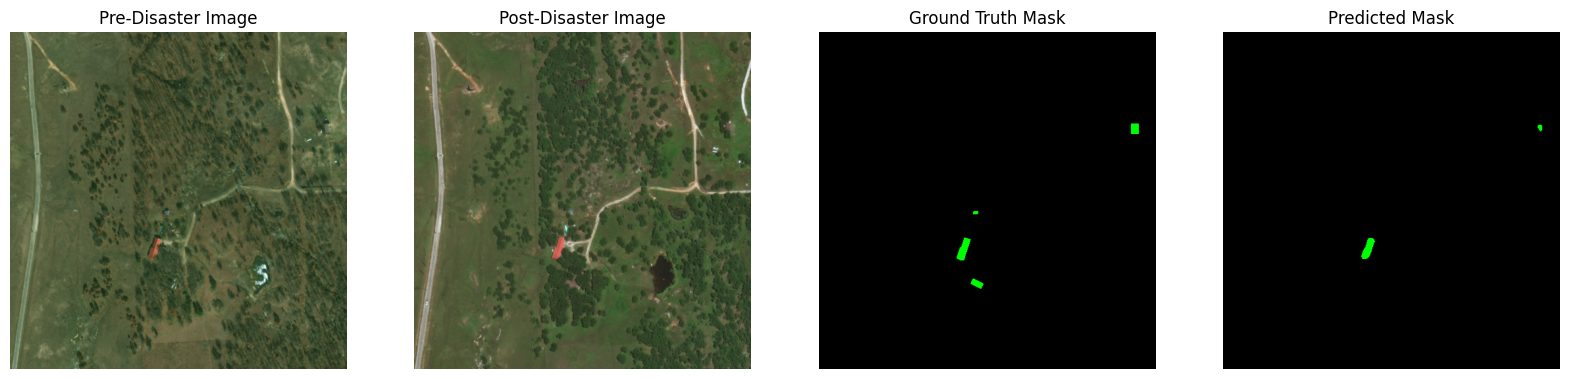

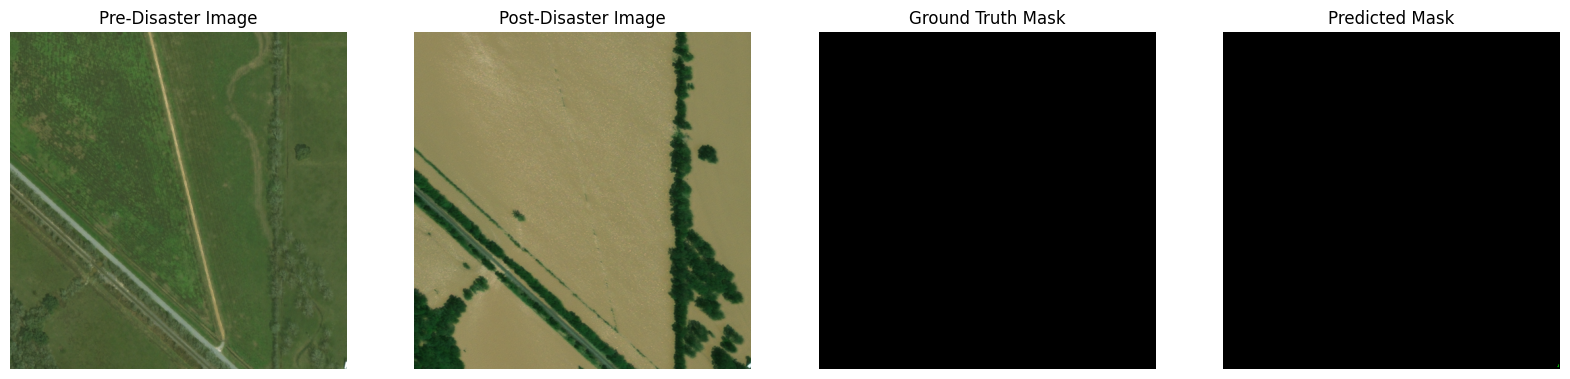

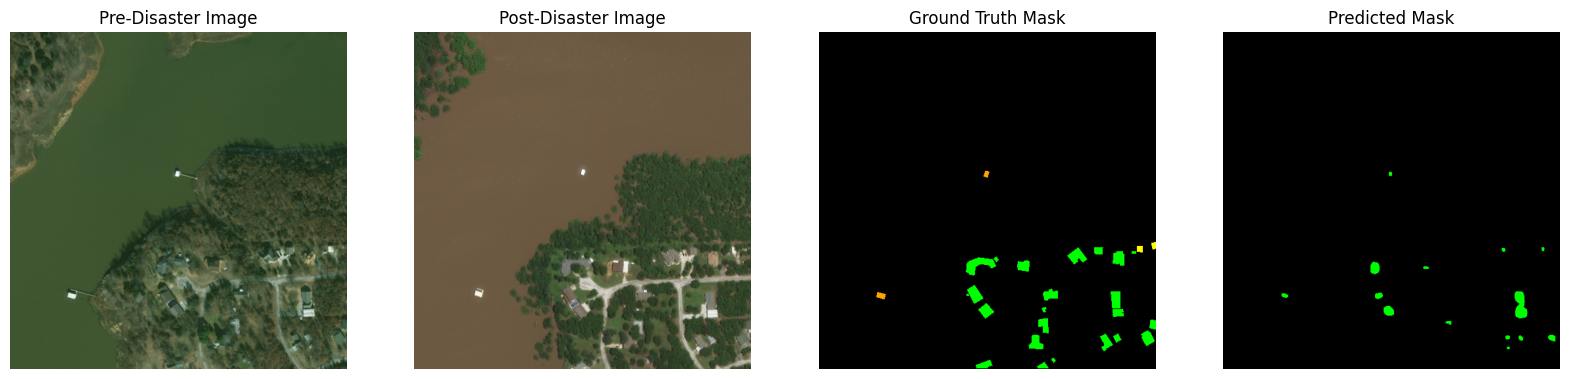

In [10]:
def visualize_predictions(generator, model, num_samples=3):
    """
    Visualizes model predictions on a few samples from the generator.
    """
    X_batch, y_batch_true = generator[0]
    y_batch_pred_prob = model.predict(X_batch)
    y_batch_pred = np.argmax(y_batch_pred_prob, axis=-1)

    color_map = np.array([[0, 0, 0], [0, 255, 0], [255, 255, 0], [255, 165, 0], [255, 0, 0]]) / 255.0

    for i in range(min(num_samples, X_batch.shape[0])):
        fig, axes = plt.subplots(1, 4, figsize=(20, 5))

        pre_img = X_batch[i, :, :, :3]
        axes[0].imshow(pre_img)
        axes[0].set_title("Pre-Disaster Image")
        axes[0].axis('off')

        post_img = X_batch[i, :, :, 3:]
        axes[1].imshow(post_img)
        axes[1].set_title("Post-Disaster Image")
        axes[1].axis('off')

        true_mask = y_batch_true[i].squeeze()
        axes[2].imshow(color_map[true_mask.astype(int)])
        axes[2].set_title("Ground Truth Mask")
        axes[2].axis('off')

        pred_mask = y_batch_pred[i]
        axes[3].imshow(color_map[pred_mask.astype(int)])
        axes[3].set_title("Predicted Mask")
        axes[3].axis('off')

        plt.show()

print("\n--- Visualizing Predictions on Validation Data ---")
visualize_predictions(val_generator, model, num_samples=3)

In [11]:
!pip install -q tensorflow==2.15.0
!pip install -q segmentation-models==1.0.1
!pip install -q kagglehub
!pip install -q osmnx
!pip install -q shapely
!pip install -q networkx
!pip install -q opencv-python
!pip install -q gdown
print("✅ All dependencies installed.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.3/475.3 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 28.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 8.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydf 0.13.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tf-keras 2.18.0 re

In [12]:
import json
import numpy as np
import osmnx as ox
import networkx as nx
from shapely.geometry import Polygon, Point
import cv2

DESTROYED_BUILDING_COST = 100000
ROAD_BUFFER_DISTANCE_METERS = 15

def get_geo_context(json_path):
    """
    Reads the label JSON to get the image's geographic bounding box and fetches the road network.
    """
    with open(json_path) as f:
        label_data = json.load(f)

    coords = [pt for feat in label_data['features']['xy'] for pt in np.array(feat['wkt'].replace('POLYGON ((', '').replace('))', '').split(','), dtype=object)]
    if not coords: return None, None, None

    all_points = np.array([list(map(float, p.split())) for p in coords])
    min_lon, min_lat = all_points.min(axis=0)
    max_lon, max_lat = all_points.max(axis=0)
    bounds = (min_lon, min_lat, max_lon, max_lat)

    G = ox.graph_from_bbox(max_lat, min_lat, max_lon, min_lon, network_type='all', simplify=True)
    G_proj = ox.project_graph(G)
    return G, G_proj, bounds

def pixel_to_geo(px, py, img_shape, geo_bounds):
    """
    Converts a single pixel coordinate to a projected geographic coordinate.
    """
    img_h, img_w = img_shape
    min_lon, min_lat, max_lon, max_lat = geo_bounds

    lon = min_lon + (px / img_w) * (max_lon - min_lon)
    lat = max_lat - (py / img_h) * (max_lat - min_lat)
    projected_point = ox.project_geometry(Point(lon, lat))[0]
    return projected_point

def get_polygons_from_mask(mask, damage_class_id):
    """
    Finds and returns polygon contours for a specific class from a mask.
    """
    class_mask = np.where(mask == damage_class_id, 255, 0).astype(np.uint8)
    contours, _ = cv2.findContours(class_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    return [cnt for cnt in contours if cv2.contourArea(cnt) > 25]
def update_graph_with_damage(G_proj, pred_mask, geo_bounds):
    """
    Identifies destroyed buildings in the mask, finds nearby roads, and penalizes them.
    """
    for _, _, _, data in G_proj.edges(keys=True, data=True):
        data['cost'] = data.get('length', 1)

    destroyed_polygons_px = get_polygons_from_mask(pred_mask, damage_class_id=4)
    if not destroyed_polygons_px:
        print("No 'destroyed' buildings detected. Routing will be based on shortest path only.")
        return G_proj
    edges_gdf = ox.graph_to_gdfs(G_proj, nodes=False)
    penalized_edge_count = 0

    for poly_px in destroyed_polygons_px:
        geo_points = [pixel_to_geo(pt[0][0], pt[0][1], pred_mask.shape, geo_bounds) for pt in poly_px]
        if len(geo_points) < 3: continue
        poly_geo = Polygon(geo_points)

        danger_zone = poly_geo.buffer(ROAD_BUFFER_DISTANCE_METERS)
        intersecting_edges = edges_gdf[edges_gdf.intersects(danger_zone)]

        for u, v, key in intersecting_edges.index:
            if G_proj.has_edge(u, v, key):
                G_proj.edges[u, v, key]['cost'] = DESTROYED_BUILDING_COST
                penalized_edge_count += 1

    print(f"Penalized {penalized_edge_count} road segments near {len(destroyed_polygons_px)} destroyed buildings.")
    return G_proj

print("✅ Core routing and geospatial functions are defined.")

✅ Core routing and geospatial functions are defined.


In [22]:
import os
import json
import osmnx as ox


def get_geo_context(json_path):
    """
    Reads a label JSON file, extracts geographic bounds, and downloads the
    corresponding road network from OpenStreetMap.
    """
    with open(json_path) as f:
        label_data = json.load(f)

    try:
        coords = label_data['metadata']['img_bounds']
        min_lon, min_lat = coords['bottom_left']
        max_lon, max_lat = coords['top_right']
    except (KeyError, TypeError):
        print(f"Warning: Could not find img_bounds in {json_path}. Skipping.")
        return None, None, None

    bbox = (max_lat, min_lat, max_lon, min_lon)

    G = ox.graph_from_bbox(bbox, network_type='all', simplify=True)

    G_proj = ox.project_graph(G)
    bounds = (min_lon, min_lat, max_lon, max_lat)

    return G, G_proj, bounds

In [29]:
import os
from PIL import Image
import matplotlib.pyplot as plt

DATASET_PATH = '/kaggle/input/xview2-challenge-dataset-train-and-test'

TRAIN_IMAGES_PATH = os.path.join(DATASET_PATH, 'train/train/images')
TRAIN_LABELS_PATH = os.path.join(DATASET_PATH,'train/train/labels' )

SAMPLE_IMAGE_ID = 'hurricane-florence_0000015'

IMG_WIDTH = 256
IMG_HEIGHT = 256

print(f"--- Processing sample: {SAMPLE_IMAGE_ID} ---")
print(f"Image Directory: {TRAIN_IMAGES_PATH}")

pre_img_path = os.path.join(TRAIN_IMAGES_PATH, f"{SAMPLE_IMAGE_ID}_pre_disaster.png")
post_img_path = os.path.join(TRAIN_IMAGES_PATH, f"{SAMPLE_IMAGE_ID}_post_disaster.png")

print(f"\nConstructed Path for Pre-Disaster Image:\n{pre_img_path}")
print(f"Constructed Path for Post-Disaster Image:\n{post_img_path}")


try:

    post_img = Image.open(post_img_path).resize((IMG_WIDTH, IMG_HEIGHT))

    pre_img = Image.open(pre_img_path).resize((IMG_WIDTH, IMG_HEIGHT))

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    axes[0].imshow(pre_img)
    axes[0].set_title(f'Pre-Disaster\n{SAMPLE_IMAGE_ID}')
    axes[0].axis('off')

    axes[1].imshow(post_img)
    axes[1].set_title(f'Post-Disaster\n{SAMPLE_IMAGE_ID}')
    axes[1].axis('off')

    plt.tight_layout()
    plt.show()

except FileNotFoundError:
    print("\n--- ERROR ---")
    print("One of the image files was not found. Please check that:")
    print("1. The DATASET_PATH is correct.")
    print("2. The SAMPLE_IMAGE_ID exists.")
    print(f"3. The file exists at the constructed path: {post_img_path}")

pre_img_path = os.path.join(TRAIN_IMAGES_PATH, f"{SAMPLE_IMAGE_ID}_pre_disaster.png")
post_img_path = os.path.join(TRAIN_IMAGES_PATH, f"{SAMPLE_IMAGE_ID}_post_disaster.png")
label_json_path = os.path.join(TRAIN_LABELS_PATH, f"{SAMPLE_IMAGE_ID}_post_disaster.json")

print("\nGenerated Paths:")
print(f"Pre-disaster image: {pre_img_path}")
print(f"Post-disaster image: {post_img_path}")
print(f"Label JSON: {label_json_path}")

pre_img_path = os.path.join(base_path, f"{SAMPLE_IMAGE_ID}_pre_disaster.png")

input_image = np.concatenate([np.array(pre_img), np.array(post_img)], axis=-1) / 255.0

pred_mask = np.argmax(model.predict(np.expand_dims(input_image, axis=0))[0], axis=-1)
print("Damage mask predicted.")

print("Damage mask predicted.")

G_orig, G_proj, geo_bounds = get_geo_context(label_json_path)

if G_proj is None:
    print(f"\n--- SKIPPING SAMPLE: {SAMPLE_IMAGE_ID} ---")
    print("Reason: Could not retrieve geographic data. The label file may be incomplete.")
else:
    print("Damage data integrated into road network graph.")
    G_damaged = update_graph_with_damage(G_proj.copy(), pred_mask, geo_bounds)

    if len(G_damaged.nodes) > 2:
        nodes = list(G_damaged.nodes)
        orig_node, dest_node = np.random.choice(nodes, 2, replace=False)
        print(f"\nCalculating routes from node {orig_node} to {dest_node}...")

        route_normal = nx.shortest_path(G_proj, orig_node, dest_node, weight='length')
        route_rerouted = nx.shortest_path(G_damaged, orig_node, dest_node, weight='cost')

        plt.suptitle(f"Damage-Aware Routing for {SAMPLE_IMAGE_ID}", fontsize=16)
        plt.show()

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
axes[0].imshow(pre_img); axes[0].set_title("Pre-Disaster"); axes[0].axis('off')
axes[1].imshow(post_img); axes[1].set_title("Post-Disaster"); axes[1].axis('off')
im = axes[2].imshow(pred_mask, cmap='jet', vmin=0, vmax=4); axes[2].set_title("AI Predicted Damage Mask"); axes[2].axis('off')
fig.colorbar(im, ax=axes[2], ticks=[0, 1, 2, 3, 4]).set_ticklabels(['BG', 'None', 'Minor', 'Major', 'Destroyed'])
plt.show()

--- Processing sample: hurricane-florence_0000015 ---
Image Directory: /kaggle/input/xview2-challenge-dataset-train-and-test/train/train/images

Constructed Path for Pre-Disaster Image:
/kaggle/input/xview2-challenge-dataset-train-and-test/train/train/images/hurricane-florence_0000015_pre_disaster.png
Constructed Path for Post-Disaster Image:
/kaggle/input/xview2-challenge-dataset-train-and-test/train/train/images/hurricane-florence_0000015_post_disaster.png

--- ERROR ---
One of the image files was not found. Please check that:
1. The DATASET_PATH is correct.
2. The SAMPLE_IMAGE_ID exists.
3. The file exists at the constructed path: /kaggle/input/xview2-challenge-dataset-train-and-test/train/train/images/hurricane-florence_0000015_post_disaster.png

Generated Paths:
Pre-disaster image: /kaggle/input/xview2-challenge-dataset-train-and-test/train/train/images/hurricane-florence_0000015_pre_disaster.png
Post-disaster image: /kaggle/input/xview2-challenge-dataset-train-and-test/train/trai

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/xview2-challenge-dataset-train-and-test/train/train/labels/hurricane-florence_0000015_post_disaster.json'

In [25]:
pip install opencv-python matplotlib scikit-image

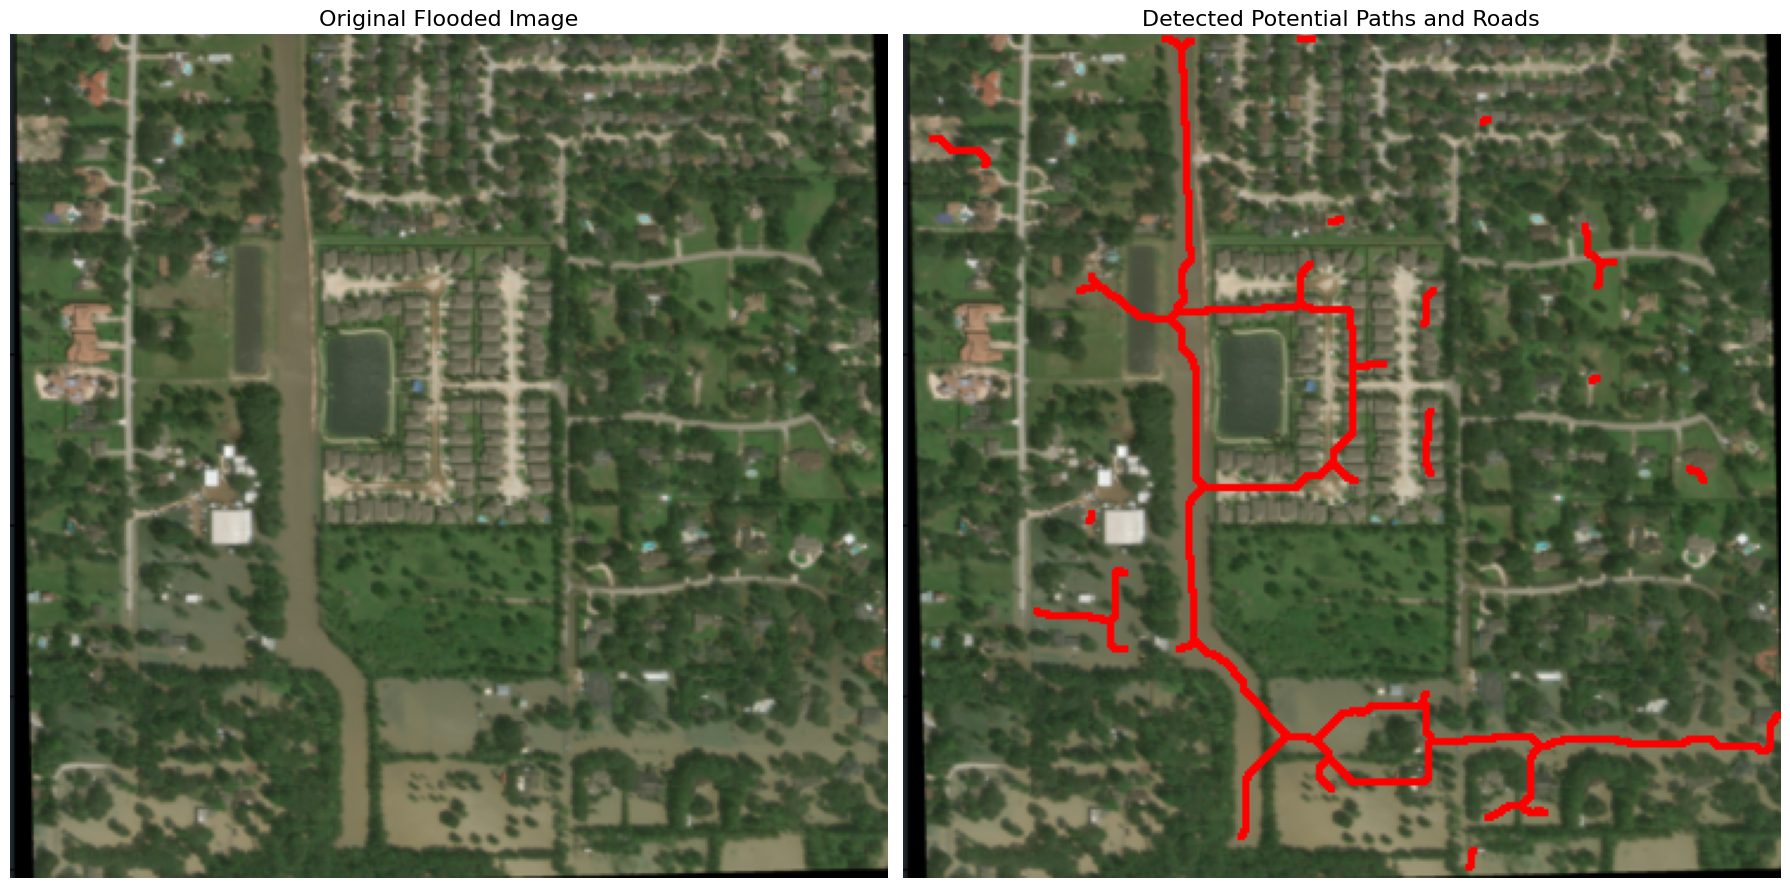

In [34]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_bool

def detect_flooded_paths(image_path):
    """
    Detects potential roads and paths in a flooded aerial image by isolating
    the floodwater and finding its morphological skeleton.

    Args:
        image_path (str): The file path to the input image.

    Returns:
        None: Displays the original and result images using matplotlib.
    """
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    blurred_image = cv2.GaussianBlur(gray_image, (7, 7), 0)

    lower_bound = 90
    upper_bound = 130
    water_mask = cv2.inRange(blurred_image, lower_bound, upper_bound)

    kernel = np.ones((5, 5), np.uint8)
    opened_mask = cv2.morphologyEx(water_mask, cv2.MORPH_OPEN, kernel, iterations=2)
    cleaned_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, kernel, iterations=3)

    bool_mask = img_as_bool(cleaned_mask)
    skeleton = skeletonize(bool_mask)

    skeleton_img = (skeleton * 255).astype(np.uint8)

    result_image = rgb_image.copy()

    display_kernel = np.ones((3, 3), np.uint8)
    dilated_skeleton = cv2.dilate(skeleton_img, display_kernel, iterations=1)

    result_image[dilated_skeleton > 0] = [255, 0, 0]

    plt.figure(figsize=(18, 9))

    plt.subplot(1, 2, 1)
    plt.imshow(rgb_image)
    plt.title('Original Flooded Image', fontsize=16)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(result_image)
    plt.title('Detected Potential Paths and Roads', fontsize=16)
    plt.axis('off')

    plt.tight_layout()
    plt.show()


image_file = '/content/test_post_0014.png'
detect_flooded_paths(image_file)

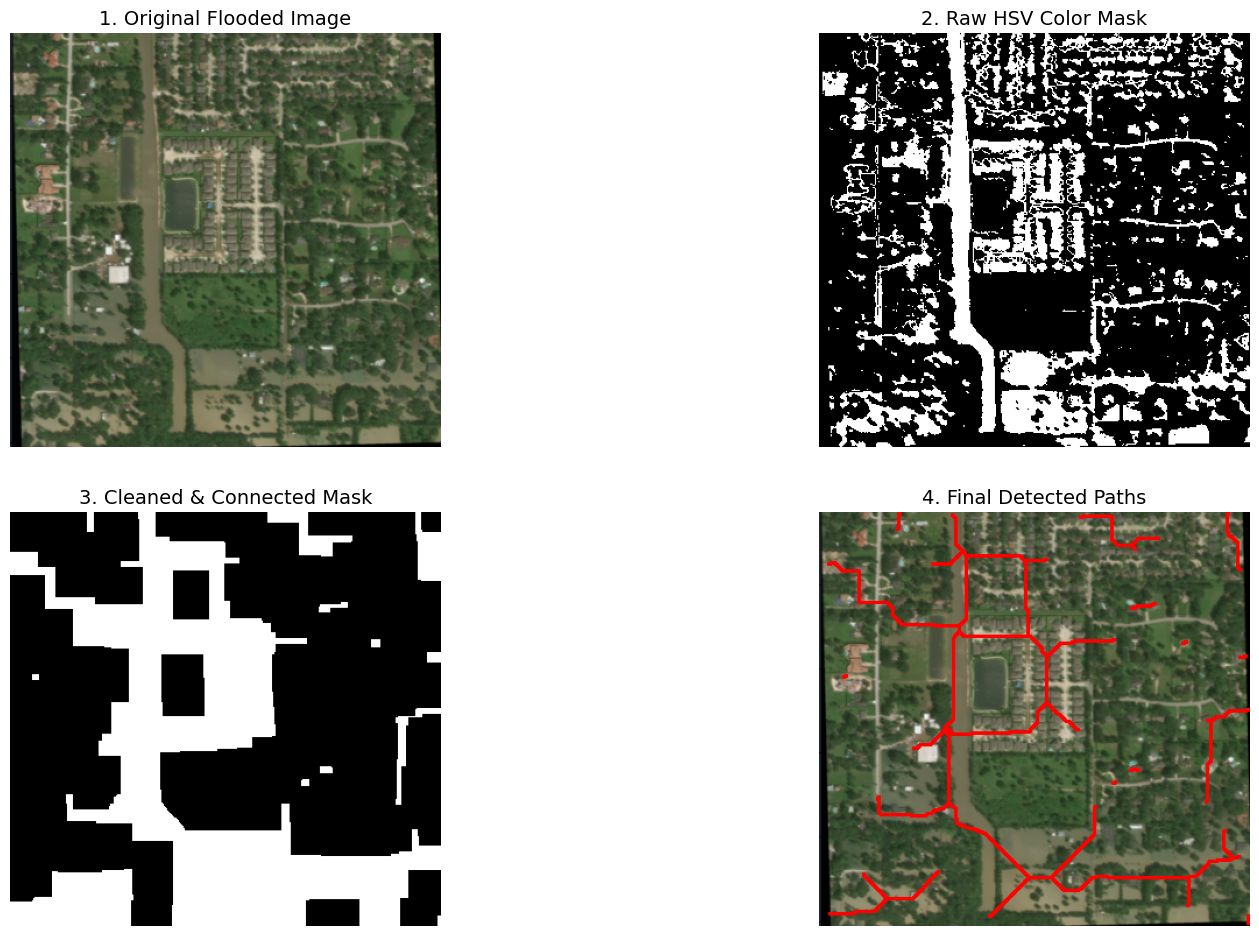

In [35]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
from skimage import img_as_bool

def detect_flooded_paths_improved(image_path):
    """
    Detects potential roads and paths in a flooded aerial image using a more
    robust method based on HSV color space segmentation and advanced morphological cleaning.

    Args:
        image_path (str): The file path to the input image.

    Returns:
        None: Displays the original image, intermediate steps, and the final result.
    """
    original_image = cv2.imread(image_path)
    if original_image is None:
        print(f"Error: Could not load image at {image_path}")
        return

    rgb_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

    hsv_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2HSV)

    lower_hsv = np.array([15, 30, 60])
    upper_hsv = np.array([35, 150, 160])

    hsv_mask = cv2.inRange(hsv_image, lower_hsv, upper_hsv)

    open_kernel = np.ones((3, 3), np.uint8)
    opened_mask = cv2.morphologyEx(hsv_mask, cv2.MORPH_OPEN, open_kernel, iterations=2)

    close_kernel = np.ones((11, 11), np.uint8)
    cleaned_mask = cv2.morphologyEx(opened_mask, cv2.MORPH_CLOSE, close_kernel, iterations=3)

    bool_mask = img_as_bool(cleaned_mask)
    skeleton = skeletonize(bool_mask)
    skeleton_img = (skeleton * 255).astype(np.uint8)

    result_image = rgb_image.copy()

    display_kernel = np.ones((3, 3), np.uint8)
    dilated_skeleton = cv2.dilate(skeleton_img, display_kernel, iterations=1)

    result_image[dilated_skeleton > 0] = [255, 0, 0]

    plt.figure(figsize=(20, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(rgb_image)
    plt.title('1. Original Flooded Image', fontsize=14)
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(hsv_mask, cmap='gray')
    plt.title('2. Raw HSV Color Mask', fontsize=14)
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(cleaned_mask, cmap='gray')
    plt.title('3. Cleaned & Connected Mask', fontsize=14)
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(result_image)
    plt.title('4. Final Detected Paths', fontsize=14)
    plt.axis('off')

    plt.tight_layout(pad=3.0)
    plt.show()

image_file = '/content/test_post_0014.png'
detect_flooded_paths_improved(image_file)